In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Benfordness

Benford's law is an observation about the frequency distribution of leading digits in many real-life sets of numerical data (https://en.wikipedia.org/wiki/Benford%27s_law). 

The law states that in many naturally occurring collections of numbers, **the leading digit is likely to be small**. In sets that obey the law, the number 1 appears as the leading significant digit about 30% of the time, while 9 appears as the leading significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time. Benford's law also makes predictions about the distribution of second digits, third digits, digit combinations, and so on.

In this notebook we upload different dasasets to see if the rule applies or not. The first striking result comes with some Youtube statistics... continue reading to find out more! 

#### Create a function that plots the distribution of the digits of a given array compared to the distribution of Benford's law

In [2]:
# distribution according to Benford's law
benford = np.array([30.1, 17.6,12.5,9.7,7.9,6.7,5.8,5.1,4.6])

The following function takes a vector w as input and returns 
- *perc*: an array of length 9 with the percentage of the appeareance of the i-th digit in w at the i-th position
- *RMSE*: the root mean squared error, measuring how far *perc* is from Benford's distribution

In [3]:
def Benford(w):
    
    # if a list is given, turn it into an numpy array
    if type(w) is not np.ndarray: w = w.to_numpy()
        
    # extract the first non zero digit
    for j in range(len(w)):
        # if the number is zero, skip
        if w[j]==0: continue
        u = str(w[j])
        # until there are zeros, skip to the next digit
        while (u[0]=='0') or (u[0]=='.'): # skip also '.' in case the number is 0.04274 for example
            u = u[1:]
        
        w[j]=int(u[0])
    
    # now w is an array with integers from 0. to 9.
    
    # count the frequency of each digit as percentage 
    count = pd.Series(w).value_counts(normalize=True).sort_index()
    
    # it might be that a digit is missing. put zero instead.
    perc = pd.DataFrame(count)
    perc.index= [int(x) for x in perc.index]
    zeros = pd.DataFrame({'zero': np.zeros(10)},np.arange(0,10))
    join_df = perc.join(zeros,how='outer').fillna(0)
    
    perc = list((join_df[0]+join_df['zero'])*100)[1:10] # EXCLUDE ZERO!
      
    # calculate root mean squared error
    RMSE = mean_squared_error(benford,perc, squared= False)/(benford.max()-benford.min())
 
    return perc, RMSE

The next function plots the percentages of a given vector compared to Benford's distribution

In [4]:
def Benford_print(w, name= 'Input'):
    perc, RMSE = Benford(w)
    
    fig = plt.fig ure()
    ax = fig.gca()
    ax.set_xticks(np.arange(1,10))
    plt.scatter(np.arange(1,10), perc, label = 'Naive')
    plt.scatter(np.arange(1,10), benford, color = 'r', label = 'Benford')
    plt.title('Comparing '+name+' and Benford distributions')
    plt.ylabel('Percentage')
    plt.xlabel('Digit')
    ax.legend([name,'Benford'])
    ax.grid(linestyle='--', linewidth=0.5)
    plt.show()
    
    print('RMSE: ', RMSE,'\n\n')

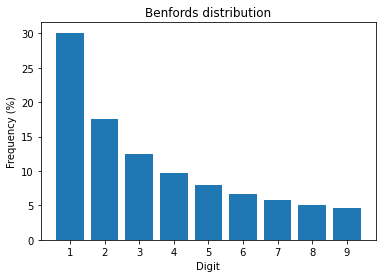

In [41]:
plt.bar(np.arange(1,10), benford, tick_label = np.arange(1,10))
plt.title('Benfords distribution')
plt.ylabel('Frequency (%)')
plt.xlabel('Digit')
plt.show()

The distribution of first digits, according to Benford's law. Each bar represents a digit, and the height of the bar is the percentage of numbers that start with that digit.

#### Let's try it on a random array

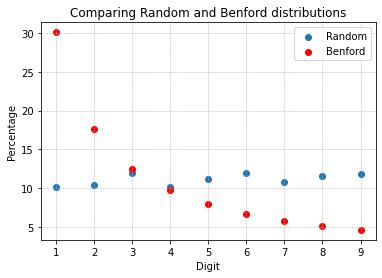

RMSE:  0.32237672639788395 




In [6]:
w = np.random.rand(5674)
Benford_print(w, 'Random')

Let's generate a number of random vectors and see the average RMSE and percentages. We expect that the digits of a uniform distribution occur about 11.11% of the time each.

In [7]:
for k in range(100):
    length = np.random.randint(1,10000)
    perc, RMSE = Benford(np.random.rand(length))
    if k ==0: 
        RMSE_ = RMSE
        perc_ = np.array([perc])
    else:
        RMSE_ = np.append(RMSE_,RMSE)
        perc_ = np.append(perc_,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_.mean())
print('Average percentages:', perc_.mean(axis=0))

Average RMSE: 0.3070165241537273
Average percentages: [11.00828696 11.12744586 11.11209423 11.09626171 11.14318001 11.10485206
 11.11050602 11.09675249 11.20062067]


#### The shape of the Benford distribution reminds me the exponential one. Let's compare them.

In [8]:
from scipy.stats import expon
data_expon = expon.rvs(scale=1,loc=0,size=1000)

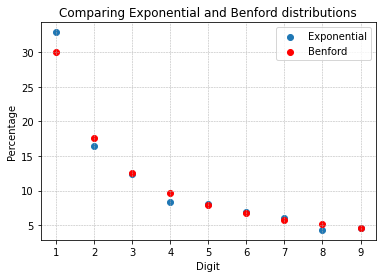

RMSE:  0.04478912862486745 




In [9]:
Benford_print(data_expon, 'Exponential')

In [10]:
# again, let's find the average RMSE

for k in range(1000):
    length = np.random.randint(1,1000)
    perc, RMSE = Benford(expon.rvs(scale=1,loc=0,size=length))
    if k ==0: 
        RMSE_ex = RMSE
        perc_ex = np.array([perc])
    else:
        RMSE_ex = np.append(RMSE_ex,RMSE)
        perc_ex = np.append(perc_ex,np.array([perc]), axis =0)
    
print('Average RMSE:', RMSE_ex.mean())
print('Average percentages:', perc_ex.mean(axis=0))

Average RMSE: 0.0879850408760855
Average percentages: [32.98156751 17.37927089 11.18269063  8.58617111  7.29942416  6.4397817
  5.78259319  5.43515239  4.91334841]


Indeed, we can see that the average RMSE here is quite low and the percentages remind the one of Benford's distribution

# Test on real data

#### Now it's time to take some real dataset and see whether Benford's law holds

- First, we take the Fraud Detection on Bank Payments dataset from Kaggle
(https://www.kaggle.com/turkayavci/fraud-detection-on-bank-payments/data)
and consider the column with the amount of the purchase 

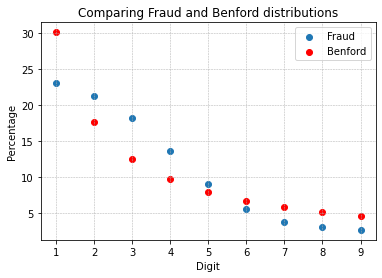

RMSE:  0.14664955548014777 




In [11]:
df = pd.read_csv('datasets/fraud_detection_bank_dataset.csv')

amount = df['amount']
Benford_print(amount, 'Fraud')

We can actually see that the lower digits appear more often than the others, but the RMSE tell us that the distributions don't agree.

- Consider now the MusicNet dataset, a collection of 330 freely-licensed classical music recordings
(https://www.kaggle.com/imsparsh/musicnet-dataset?select=musicnet_metadata.csv)
and its column with the duration of the recording in seconds.

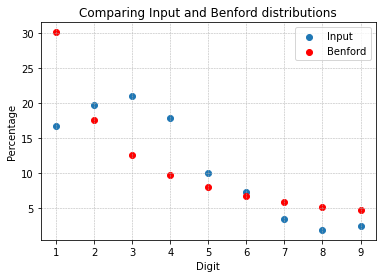

RMSE:  0.2441275146594341 




In [12]:
df_1 = pd.read_csv('datasets/musicnet_metadata.csv')

sec = df_1['seconds']
Benford_print(sec)

Here unfortunately the result is even worse... 

- Let's turn to other strtistics, the Trending YouTube Video Statistics
(https://www.kaggle.com/datasnaek/youtube-new?select=USvideos.csv).
 Here we can consider different columns, such as 'views', 'likes', 'dislikes', 'comment_count'

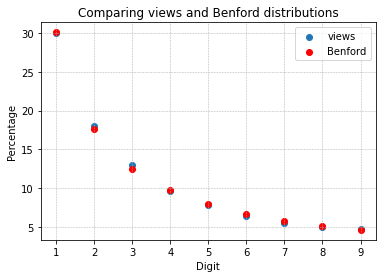

RMSE:  0.00928091004746307 




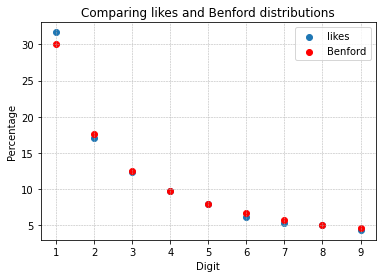

RMSE:  0.023828268477435136 




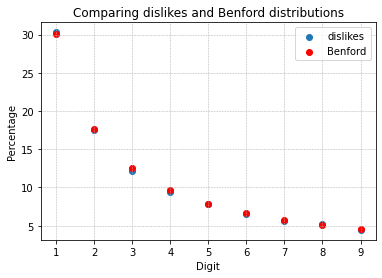

RMSE:  0.0078072070125858066 




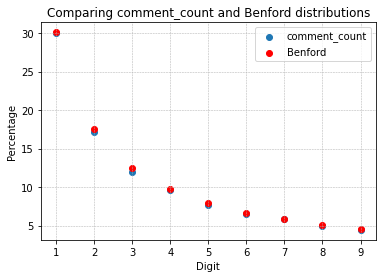

RMSE:  0.010653841084520414 




In [13]:
dfYT = pd.read_csv('datasets/USvideos.csv')

attr = ['views', 'likes', 
        'dislikes', 'comment_count']

dfYT_copy= dfYT.copy()
for col in attr:
    Benford_print(dfYT_copy[col],col)

WOW!! I don't need to explain the results... it fits perfectly :) 
We could try to study the outliars and see what they have in common. 

- Next, I'd like to look at some measures. For example, take the 
Body Measurements Dataset from Kaggle
(https://www.kaggle.com/saurabhshahane/body-measurements-dataset)

In [14]:
df_body = pd.read_csv('datasets/Body Measurements _ original_CSV.csv')

df_body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             715 non-null    float64
 1   Age                716 non-null    int64  
 2   HeadCircumference  716 non-null    int64  
 3   ShoulderWidth      716 non-null    int64  
 4   ChestWidth         716 non-null    int64  
 5   Belly              716 non-null    int64  
 6   Waist              716 non-null    int64  
 7   Hips               716 non-null    int64  
 8   ArmLength          716 non-null    int64  
 9   ShoulderToWaist    716 non-null    int64  
 10  WaistToKnee        716 non-null    int64  
 11  LegLength          716 non-null    int64  
 12  TotalHeight        716 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 72.8 KB


In [15]:
print('Average RMSE of each column: \n')
for col in df_body.columns[1:]:
    print(col,': ', Benford(df_body[col])[1], '\n')

Average RMSE of each column: 

Age :  0.07858886306725872 

HeadCircumference :  0.7884094869801769 

ShoulderWidth :  0.7316951073784834 

ChestWidth  :  0.649300847652099 

Belly  :  0.5277035149890056 

Waist  :  0.42349067676410057 

Hips  :  0.4341199980435674 

ArmLength  :  0.5019342549960807 

ShoulderToWaist  :  0.5272277860308319 

WaistToKnee  :  0.5248075906442526 

LegLength :  0.5079469883015781 

TotalHeight :  0.6016175777473305 



Only 'Age' seems following Benford's distribution:


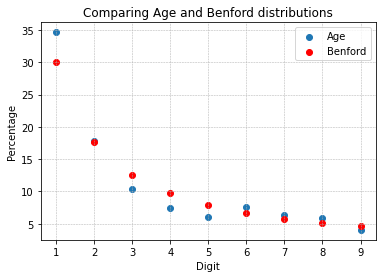

RMSE:  0.07858886306725872 




In [16]:
Benford_print(df_body['Age'], 'Age')

# Youtube statistics

#### After the surprising result on the "Benfordness" of the Youtube statistics, let's study in more detail the YouTube dataframe.

In [17]:
dfYT.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."


#### Missing values. 

Only some rows in the 'description' column have NaN values. I don't find interesting this column anyway, I'll drop it.

In [18]:
dfYT.drop(['description'], axis=1, inplace= True)

#### There is a column named "video_id": can I use it as index of the dataframe? 

In [19]:
print('Length of the DataFrame: ',len(dfYT))
print('Unique video_id: ',len(dfYT.video_id.unique()))

Length of the DataFrame:  40949
Unique video_id:  6351


There are **6351 unique video_id** over a total of 40949 videos. Why?
Let's have a closer look at the duplicates.

In [20]:
dfYT[dfYT.duplicated()==True]['trending_date'].unique()

array(['18.15.05'], dtype=object)

All the duplicates have tranding_date equal to 18.15.05. There must have been a mistake on this day (yes, the day format is confusing.. we'll have a look at this later) 

On the other hand, have all the videos with same video_id a different trending_date? 

In [21]:
print(len(dfYT[dfYT['video_id']=='j4KvrAUjn6c']))
print(len(dfYT[dfYT['video_id']=='j4KvrAUjn6c']['trending_date'].unique()))

30
29


For example, there are 30 rows with video_id = j4KvrAUjn6c. Except the 18.15.05 which has a duplicate, all the other trending days are different. 

At this point I assume 
the rows represent the statistics (views/likes/etc) PER DAY.
Let's drop the duplicates and confirm that all the unique video_id's have different trending_date.

In [22]:
duplicates = dfYT[dfYT.duplicated()==True].index

dfYT.drop(labels = duplicates, axis = 0 , inplace = True)

duplic_df = dfYT[dfYT.duplicated(subset = ['video_id'], keep = False)==True]

for i in duplic_df['video_id'].unique():
    if len(duplic_df[duplic_df['video_id']==i]['trending_date'].unique())!= len(duplic_df[duplic_df['video_id']==i]):
        print(i)

YI3tsmFsrOg
vY_5EvoL1Is


There are only two videos that share the same trending_date. Let's see why.

In [23]:
dfYT[dfYT['video_id']== 'YI3tsmFsrOg']   # the indices 34763 and 34912 are the ones
dfYT.loc[34763]==dfYT.loc[34912]         # the only difference is in the number of likes: 197843 vs 197847
# it doesn't change much!

dfYT[dfYT['video_id']== 'vY_5EvoL1Is']   # the indices 34771 and 34920 are the ones
dfYT.loc[34771]==dfYT.loc[34920]         # same here, only likes and dislikes are different, but not too far! 
 
dfYT.drop(labels = [34763, 34771], axis = 0 , inplace = True)

I confirm the hypothesis that **we're looking at the statistics PER TRENDING DAY**. There must have been a mistake for two videos, but we fixed it.

Anyway, the answer to the question 'can I use video_id as index?' is **no**.

#### More about the columns of the dataframe:

In [24]:
dfYT.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed'],
      dtype='object')

In [25]:
cols = ['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time']

for c in cols:
    print (c, ' has ', len(dfYT[c].unique()) , ' unique values')

video_id  has  6351  unique values
trending_date  has  205  unique values
title  has  6455  unique values
channel_title  has  2207  unique values
category_id  has  16  unique values
publish_time  has  6269  unique values


#### I'm courious about how old are the videos and how long they remained in the trends

In [26]:
dfYT['publish_time'] = pd.to_datetime(dfYT['publish_time'])
dfYT['publish_day'] = dfYT['publish_time']
for i in dfYT.index:
    dfYT['publish_day'][i] = dfYT['publish_time'][i].replace(hour=0, minute=0, second = 0)

print('Oldest video: ', min(dfYT['publish_day']).date())
print('Most recent video: ', max(dfYT['publish_day']).date())

Oldest video:  2006-07-23
Most recent video:  2018-06-14


How many days later after the publication a video goes in the trends?

In [27]:
# dfYT['trending_date'] = pd.to_datetime(dfYT['trending_date'])
# it looks the dates have a strange format... convert it to timedate accordingly
dfYT['trending_date'] = pd.to_datetime(dfYT['trending_date'], format = '%y.%d.%m')
# don't consider timezone of the published time, as I don't know the one of the trending date
dfYT['publish_time'] = dfYT['publish_time'].apply(lambda x: x.replace(tzinfo=None))
# calculate the delta
diff = dfYT['trending_date']-dfYT['publish_time']

print ('Minimum time before being trendy: ', diff.min().days, ' days')
print ('Maximum time before being trendy: ', diff.max().days, ' days \n')
print ('Average time: ', diff.mean().days, ' days')
print ('Median time: ', diff.median().days, ' days')

dfYT['trending_time'] = diff

Minimum time before being trendy:  -1  days
Maximum time before being trendy:  4214  days 

Average time:  16  days
Median time:  4  days


Mean value and median are quite different.. **Most of the videos are viral in very short time!**

In [28]:
print('There are on average ', dfYT['trending_date'].value_counts().mean(), ' trending videos on youtube per day')
print('The median is ', dfYT['trending_date'].value_counts().median())
print('Standard deviation: ', dfYT['trending_date'].value_counts().std())

There are on average  199.50731707317073  trending videos on youtube per day
The median is  200.0
Standard deviation:  3.6104688634134026


Youtube trending videos are on average 200 per day and do not deviate much from the mean. It must be some YouTube rule.

In [29]:
dfYT_18 = dfYT[dfYT['publish_day']>pd.to_datetime('2018-01-01', utc = True)].copy()
len(dfYT_18)/len(dfYT)

0.735788161079733

Most of the videos (73% of the total) are published in 2018. 

## Back to Benfordness

Now that we've cleaned the dataframe, let's see if the Benfordness has changed

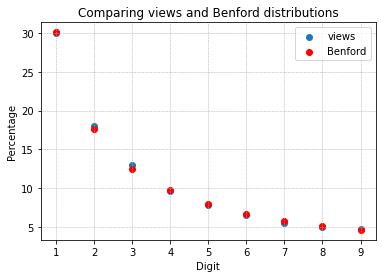

RMSE:  0.009267400980231443 




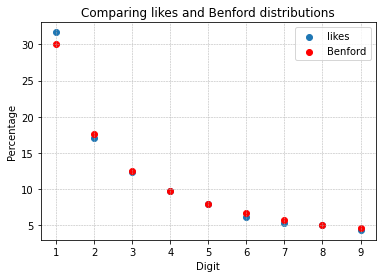

RMSE:  0.023884716117027867 




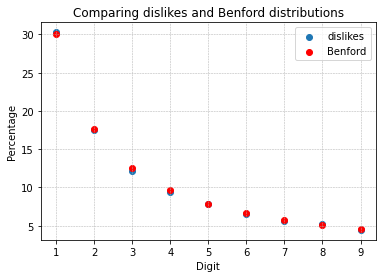

RMSE:  0.007770423587948207 




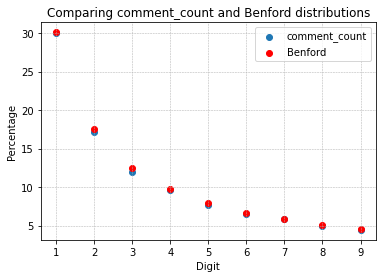

RMSE:  0.010564034722466942 




In [30]:
dfYT_copy= dfYT.copy()
for col in attr:
    Benford_print(dfYT_copy[col],col)

As we have previously seen in the Benforness.ipynb file, this attributes follow Benford's law.

Now that we know that these numbers are views/likes/etc per day, **let's see the behaviour of the total numbers per video**. To do so, we create a new dataframe with the total numbers of views, likes, dislikes and comments adding up the ones per day.

In [31]:
ind_new = list(dfYT.video_id.unique())   
cols_new_num = {'total_'+att: list(dfYT.groupby('video_id')[att].sum()) for att in ['views', 'likes', 'dislikes', 'comment_count']}

tot_dfYT = pd.DataFrame(data = cols_new_num, columns = ['total_views', 'total_likes', 'total_dislikes', 'total_comment_count'] , index = ind_new)
tot_dfYT.head()

,total_views,total_likes,total_dislikes,total_comment_count
2kyS6SvSYSE,4134702,52197,1646,2215
1ZAPwfrtAFY,563746,4429,54,94
5qpjK5DgCt4,5507675,112165,1503,4386
puqaWrEC7tY,777243,27305,713,2928
d380meD0W0M,208304,1351,76,62


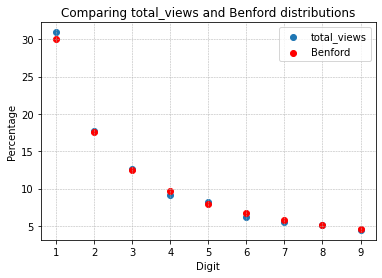

RMSE:  0.01581058960620055 




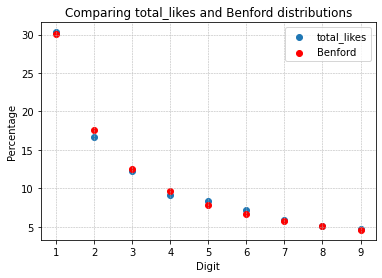

RMSE:  0.017128534026187407 




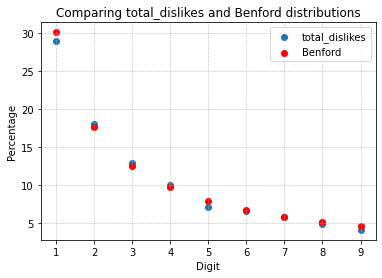

RMSE:  0.021240790793031424 




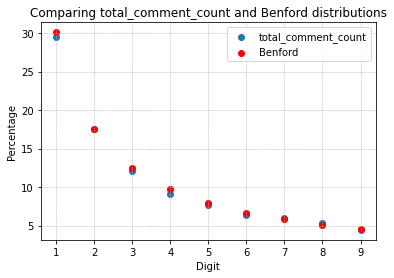

RMSE:  0.013482032076870947 




In [32]:
dfYT_copy= tot_dfYT.copy()
for col in tot_dfYT.columns:
    Benford_print(dfYT_copy[col],col)

Even the sums follow the law!! :)

## Benfordness per channel:

In [33]:
dfYT.channel_title.value_counts()

ESPN                                      202
The Tonight Show Starring Jimmy Fallon    197
Netflix                                   193
TheEllenShow                              192
Vox                                       192
                                         ... 
PetaPixel                                   1
That Japanese Man Yuta                      1
ClovesVEVO                                  1
onsetfacilities.com                         1
Just Marcus                                 1
Name: channel_title, Length: 2207, dtype: int64

There are 2207 different channels. I'd like to check the **Benfordness of the 5 channels that have an higher number of published videos**. To do so, I need the tot_dfYT dataframe.

In [34]:
video_id_channels = dfYT[['video_id', 'channel_title']]
d = video_id_channels[video_id_channels.duplicated()==True].index
video_id_channels= video_id_channels.drop(labels = d, axis = 0)

# there are too many videos.. there might be typos in the channel_title column.
# I'll be brutal and erase all duplicates:
d_more = video_id_channels[video_id_channels['video_id'].duplicated()==True]
video_id_channels = video_id_channels.drop(labels = d_more.index, axis = 0 )

video_id_channels = video_id_channels.set_index('video_id')
tot_dfYT ['channel_title'] = video_id_channels['channel_title']

In [35]:
top_5 = tot_dfYT.channel_title.value_counts()[:5].index

# create a dictionary with {'channel title': mean squared error, ....}
RMSE_dict = {}

for channel in top_5:
    df_ch = tot_dfYT[tot_dfYT['channel_title']==channel]
    c, rmse = Benford(df_ch['total_views'])
    RMSE_dict[channel] = rmse
    print(channel, rmse)
    
c, rmse = Benford(tot_dfYT['total_views'])
print('\nTotal RMSE: ', rmse)

ESPN 0.11383060075671195
TheEllenShow 0.05226750212424962
The Tonight Show Starring Jimmy Fallon 0.1346290063301371
Jimmy Kimmel Live 0.1904650222829389
Netflix 0.13279232021166784

Total RMSE:  0.01581058960620055


The channel themselves don't have a very low RMSE (but yet not too high: less then 0.15 on average). The point here, which is the point of Benford's law, is that it holds for large collections of data from the real world. When we look at a specific object (in this case one channel) we loose Benfordness. 

To conclude our analysis, let us study the categories.

## Benfordness per category

To know which category corresponds to a give number, let's extract the category names using JSON.

In [36]:
import json

category_id_filepath = 'datasets/US_category_id.json'
category_id_json = open(category_id_filepath)

raw_category_data = json.load(category_id_json)

category_data = {}

for item in raw_category_data['items']:
    category_data[int(item['id'])] = item['snippet']['title']

# Mapping category data into the dataframe
dfYT['category'] = dfYT['category_id'].apply(lambda x: category_data.get(x, 'N/A'))

In [37]:
dfYT['category'].unique()

array(['People & Blogs', 'Entertainment', 'Comedy',
       'Science & Technology', 'Film & Animation', 'News & Politics',
       'Sports', 'Music', 'Pets & Animals', 'Education', 'Howto & Style',
       'Autos & Vehicles', 'Travel & Events', 'Gaming',
       'Nonprofits & Activism', 'Shows'], dtype=object)

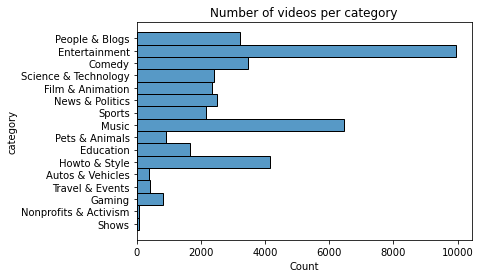

In [38]:
sns.histplot(data = dfYT, y = 'category')
plt.title('Number of videos per category')
plt.show()

The most common category is "Entertainment", followed by "Music". Unfortunately in last position we find "Nonprofits & Activism"... Sadly reflects the world we're living in...

In [39]:
# create a dictionary with {'category': mean squared error, ....}
RMSE_dict_cat = {}

for cat in dfYT.category.unique():
    df_cat = dfYT[dfYT['category']==cat]
    c, rmse = Benford(df_cat['views'])
    RMSE_dict_cat[cat] = rmse
    
print('Root mean squared error of Benfordness per category: \n')
dict(sorted(RMSE_dict_cat.items(), key=lambda item: item[1]))

Root mean squared error of Benfordness per category: 



{'Music': 0.023952105827685227,
 'Entertainment': 0.025996774530119796,
 'News & Politics': 0.034321885292735665,
 'Sports': 0.04206557910943248,
 'People & Blogs': 0.04635494470694202,
 'Science & Technology': 0.051363188239379264,
 'Film & Animation': 0.05831931217699032,
 'Howto & Style': 0.06308594123741527,
 'Gaming': 0.06669090889018069,
 'Comedy': 0.0911073523219814,
 'Pets & Animals': 0.09715325914590918,
 'Autos & Vehicles': 0.09935250412470371,
 'Travel & Events': 0.1062091088270311,
 'Education': 0.1381705415229315,
 'Nonprofits & Activism': 0.2786996533307347,
 'Shows': 0.7734845510876377}

In [40]:
val_count = dfYT.category.value_counts().values

rmse_cat = dict(sorted(RMSE_dict_cat.items(), key=lambda item: item[1]))
rmse_cat_col = [rmse_cat[i] for i in dfYT.category.value_counts().index]

category_df =pd.DataFrame({'rmse_cat': rmse_cat_col, 'count': val_count}, index = dfYT.category.value_counts().index)
category_df

,rmse_cat,count
Entertainment,0.025997,9943
Music,0.023952,6467
Howto & Style,0.063086,4142
Comedy,0.091107,3453
People & Blogs,0.046355,3208
News & Politics,0.034322,2485
Science & Technology,0.051363,2397
Film & Animation,0.058319,2343
Sports,0.042066,2172
Education,0.138171,1654


According to the fact that with a larger amount of data it's easier to find Benfordness, note that the two most sttractive categories have the lowest rmse, and thus better follow Benford's law.

# Conclusions

Benford's law looked so crazy at a first glance that I could not believe it. 
My mathematical sense had to investigate more to confirm it holds true!
The main point is that if Benford's law is true, then the significant digits of real-world data are statistically dependent. How could it be possible??
Unfortunaly, I did not answer at the 'how' question, but
I had really fun writing this notebook. The main conclusion I can draw are:

1) Now I believe in Benfordness.
2) The law tends to be more accurate when whe have more values and when they are distributed across multiple orders or magnitude. That's why when we focussed on videos of a given channel or a certain category the error increased.
3) Benforness do not depend on the unit of the measurement (the so-called scale-invariance): taking videos per day or the total number of videos don't affect Benfordness.

I hope this notebook stimulated your curiosity and that you'll look for Benfordness in the data you're studying ;) 
Please leave a comment with your results!